## 3. RNA-seqカウントデータの前処理
ここからは実際のRNA-seqカウントデータを使います。

#### RNA-seqとは
RNA-seqとは, 細胞中のmRNAやmiRNAの配列をシーケンスして、発現量の定量や新規転写産物の同定を行う手法です。<br>
シーケンスで得られたデータ（リード）は, 以下のようなステップで解析します。<br>
1. リードのトリミング
2. ゲノム配列へのマッピング
3. マッピングされたリード数を数える
4. サンプル毎の総リード数の違いや、遺伝子配列長の違いを補正（正規化） 
5. 遺伝子毎の発現量を同定、比較

本講義では上記ステップのうち4以降を扱います。

####  本講義で用いるRNA-seqデータについて
本講義では, 異なる2条件で培養された酵母のRNA-seqデータを使用します。<br>

Intawat Nookaew, Marta Papini, Natapol Pornputtapong, Gionata Scalcinati, Linn Fagerberg, Matthias Uhlén, Jens Nielsen, A comprehensive comparison of RNA-Seq-based transcriptome analysis from reads to differential gene expression and cross-comparison with microarrays: a case study in Saccharomyces cerevisiae, Nucleic Acids Research, Volume 40, Issue 20, 1 November 2012, Pages 10084–10097, https://doi.org/10.1093/nar/gks804 <br>

このRNA-seqデータはDDBJのSRAデータベース（ https://www.ddbj.nig.ac.jp/dra/index.html ）に アクセッション番号 SRR453566 ~ SRR453571 としてアーカイブされています。SRR453566 ~ SRR453568 の3つはBatch培養（通常のグルコース濃度培地）のサンプルから得られたデータ, SRR453569 ~ SRR453571 の3つはChemostat培養（低グルコース濃度培地）のサンプルから得られたデータです。いずれもBiological triplicatesです。このほか, サンプルの詳細は上記の論文を参照してください。<br>

アーカイブされたデータをダウンロードして遺伝子ごとのカウントデータにするまでの手順と, 使用したソフトウェアは以下の通りです。<br>

1. リードとリファレンスの準備 fastq-dump ver. 2.8.2 ( https://github.com/ncbi/sra-tools )
2. リードクオリティチェック FastQC ver. 0.11.8 ( http://www.bioinformatics.babraham.ac.uk/projects/fastqc/ )
3. リードの前処理 (リードトリミング、アダプター配列の除去) Trimmomatic ver. 0.38 ( Bolger et al., 2014 )
4. リードをリファレンスゲノムにマッピング HISAT2 ver. 2.1.0 ( Kim et al., 2015 )
5. 遺伝子毎にリードカウント featureCounts ver. 1.6.2 ( Liao et al., 2014 )

時間の関係で, これらの処理の詳しい内容については本講習会では扱いません。実行スクリプトなど, 詳しい内容は「先進ゲノム支援2018年度情報解析講習会（中級者向け）」 ( https://www.genome-sci.jp/lecture20181st )の配布資料をごらんください。

__本講義で行うRNA-seqデータの処理__<br>

本講義では, 以下のような処理を主にpandasを用いて行います。<br>
- データの読み込み
- 遺伝子のアノテーション( gene idに対応したproduct )
- カウントデータの正規化（ RPM/FPM, FPKM, TPM)
- 発現変動遺伝子の抽出
- サンプル間のクラスタリング　

### 3-1.データファイルの読み込み

#### 準備
pandas を pd としてインポートします。同様に numpy を np としてインポートします。

In [2]:
# pandasのimport
import pandas as pd
import numpy as np

SRR453566 ~ SRR453571 のカウントデータをまとめたファイル ( counts.txt ) のパスを指定します。<br>
同様にgene id と description を紐づけたファイル ( gene_id_product.tsv ) のパスも指定します。

In [3]:
count_file = 'input/counts.txt'
gene_id_product_file = 'input/gene_id_product.tsv'

#### カウントデータファイルについて<br>
counts.txtを開くと以下のようになっています。<br>
```
# Program:featureCounts v1.6.2; Command:"../tools/subread-1.6.2-Linux-x86_64/bin/featureCounts" "-p" "-T" "8" "-t" "exon" "-g" "gene_id" "-a" "../reference/s288c_e.gff" "-o" "../featurecount/counts.txt" "SRR453566.sorted.bam" "SRR453567.sorted.bam" "SRR453568.sorted.bam" "SRR453569.sorted.bam" "SRR453570.sorted.bam" "SRR453571.sorted.bam" 
Geneid  Chr     Start   End     Strand  Length  SRR453566.sorted.bam    SRR453567.sorted.bam    SRR453568.sorted.bam    SRR453569.sorted.bam    SRR453570.sorted.bam    SRR453571.sorted.bam
gene_0001       NC_001133.9     1807    2169    -       363     1       3       2       0       0       1
gene_0002       NC_001133.9     2480    2707    +       228     0       0       0       0       0       0
gene_0003       NC_001133.9     7235    9016    -       1782    0       0       0       0       0       0
gene_0004... 以下省略
```
1行目はfeatureCountsの実行条件が記載されているだけなので無視します。<br>
2行目は列タイトルを表すヘッダー行です。<br>
3行目以降からがデータ行です。一番左の列が遺伝子idになっているのでこれをインデックスに用います。

`pd.read_table()` メソッドの`skiprows`、`index_col`オプションを指定して読み込みます。<br>

- skiprows...データフレームに読み込まない行（ファイルの先頭行を0として数える）を数字で指定します。リストで指定することもできます。
- index_col...インデックスとして用いる列を数字で指定します。

In [4]:
df = pd.read_table(count_file, index_col=0, skiprows=1) 
# pd.read_table(count_file, index_col=0, header=1)  でも同じ

`pd.read_table(path/to/file)` のかわりに`pd.read_csv(path/to/file,sep='\t') `を用いることもできます。<br>
`sep='\t'`は`delimiter='\t'` も使えます。

#### データの概観
データを概観してみましょう。

In [5]:
df.head()

,Chr,Start,End,Strand,Length,SRR453566.sorted.bam,SRR453567.sorted.bam,SRR453568.sorted.bam,SRR453569.sorted.bam,SRR453570.sorted.bam,SRR453571.sorted.bam
Geneid,,,,,,,,,,,
gene_0001,NC_001133.9,1807,2169,-,363,0,2,6,0,0,1
gene_0002,NC_001133.9,2480,2707,+,228,0,0,0,0,0,0
gene_0003,NC_001133.9,7235,9016,-,1782,0,0,0,0,0,0
gene_0004,NC_001133.9,11565,11951,-,387,0,0,0,0,0,0
gene_0005,NC_001133.9,12046,12426,+,381,2,8,10,6,7,18


In [6]:
df.Start.head()

Geneid
gene_0001     1807
gene_0002     2480
gene_0003     7235
gene_0004    11565
gene_0005    12046
Name: Start, dtype: object

StartとEndはobject型なので, もしこれらを使って何らかの計算をしたいときは数値型に変換します(本講義では扱いません)。

カウントデータファイルの行数と列数を確認

In [7]:
df.shape

(6420, 11)

#### 列名を変更する

In [8]:
# 列名を変更するための対応表
names = {'SRR453566.sorted.bam': 'batch_1',
         'SRR453567.sorted.bam': 'batch_2',
         'SRR453568.sorted.bam': 'batch_3',
         'SRR453569.sorted.bam': 'chemostat_1',
         'SRR453570.sorted.bam': 'chemostat_2',
         'SRR453571.sorted.bam': 'chemostat_3'}

`rename_axis()` を `axis=1` を適用して使い、列名を変更します。

In [9]:
df = df.rename(mapper=names, axis=1)

`rename()` を使わなくても、既存の列を別名でコピーした後で元の列を削除、という方法でも可能です。
```
df['batch_1'] = df['SRR453566.sorted.bam']
del df['SRR453566.sorted.bam']
```

In [10]:
df.head()

,Chr,Start,End,Strand,Length,batch_1,batch_2,batch_3,chemostat_1,chemostat_2,chemostat_3
Geneid,,,,,,,,,,,
gene_0001,NC_001133.9,1807,2169,-,363,0,2,6,0,0,1
gene_0002,NC_001133.9,2480,2707,+,228,0,0,0,0,0,0
gene_0003,NC_001133.9,7235,9016,-,1782,0,0,0,0,0,0
gene_0004,NC_001133.9,11565,11951,-,387,0,0,0,0,0,0
gene_0005,NC_001133.9,12046,12426,+,381,2,8,10,6,7,18


#### ミトコンドリア上の遺伝子を除く

counts.txt にはミトコンドリア上の遺伝子も含まれるのでこれを除きます。  
Chr列 NC_001224.1 がミトコンドリアに該当します。

In [11]:
df = df[df.Chr != 'NC_001224.1']

In [12]:
df.shape

(6394, 11)

### 3-2. 遺伝子にアノテーションをつける
#### gene_idとproductの一覧ファイルを読み込む
gene_id_product.tsvを開くと以下のようになっています。<br>

```
gene_0001	seripauperin PAU8
gene_0002	hypothetical protein
gene_0003	putative permease SEO1
gene_0004	hypothetical protein
gene_0005	hypothetical protein
gene_0006	Tda8p
gene_0007...
```
ヘッダー行がないので、`names` オプションでカラム名を指定して読み込みます。


In [13]:
gene_products = pd.read_table(gene_id_product_file, index_col=0, names=['gene_id', 'product'])

gene_id 列がインデックスとなります。

In [14]:
gene_products.head()

,product
gene_id,
gene_0001,seripauperin PAU8
gene_0002,hypothetical protein
gene_0003,putative permease SEO1
gene_0004,hypothetical protein
gene_0005,hypothetical protein


#### 2つのデータフレームを連結
2つのデータフレーム `df` と `gene_products` を連結します。<br>
`gene_products` には mRNA のデータしか含まれていないので、rRNA などのデータはこの時点で除かれます。<br>
ミトコンドリア遺伝子は `gene_products` に含まれていないので、3-1.の「ミトコンドリア遺伝子を除く」操作は本当は不要です。

In [15]:
df_with_product = gene_products.join(df)

In [16]:
# mergeを使った場合
# pd.merge(gene_products, df, left_index=True, right_index=True) 

In [17]:
# concatを使った場合
# pd.concat([gene_products, df], axis=1, join="inner")

In [18]:
df_with_product.head()

,product,Chr,Start,End,Strand,Length,batch_1,batch_2,batch_3,chemostat_1,chemostat_2,chemostat_3
gene_id,,,,,,,,,,,,
gene_0001,seripauperin PAU8,NC_001133.9,1807,2169,-,363,0,2,6,0,0,1
gene_0002,hypothetical protein,NC_001133.9,2480,2707,+,228,0,0,0,0,0,0
gene_0003,putative permease SEO1,NC_001133.9,7235,9016,-,1782,0,0,0,0,0,0
gene_0004,hypothetical protein,NC_001133.9,11565,11951,-,387,0,0,0,0,0,0
gene_0005,hypothetical protein,NC_001133.9,12046,12426,+,381,2,8,10,6,7,18


####  カウントデータ部分のみを切り出し

In [19]:
df_count = df_with_product[['batch_1','batch_2','batch_3','chemostat_1','chemostat_2','chemostat_3']]

スライスで指定するなら　`df_with_product.iloc[:, 6:12]` とします。

#### ファイルの保存
アノテーション付きカウントデータを`count_preprocessed.tsv`として保存します。<br>
rawカウントのデータを`count_raw.tsv`として保存します。

In [18]:
# アノテーション付きデータの保存
df_with_product.to_csv('output/count_preprocessed.tsv', sep='\t')

In [19]:
# raw カウントのデータの保存
df_count.to_csv('output/count_raw.tsv', sep='\t')

シェルコマンド head を使って確認してみます。<br>
`%%bash`でJupyter notebookのセル内でbashコマンドを実行させることができます。

In [20]:
%%bash
head output/count_raw.tsv

gene_id	batch_1	batch_2	batch_3	chemostat_1	chemostat_2	chemostat_3
gene_0001	0	2	6	0	0	1
gene_0002	0	0	0	0	0	0
gene_0003	0	0	0	0	0	0
gene_0004	0	0	0	0	0	0
gene_0005	2	8	10	6	7	18
gene_0006	0	0	0	0	0	0
gene_0007	0	0	0	0	0	0
gene_0008	0	0	0	0	0	0
gene_0009	32	37	33	43	63	84


### 3-3. カウントデータの正規化
#### 3-3-1. リード数で正規化 (RPM/FPM)

100万リードあたりのカウント数に揃えます。<br>
RPM = reads per million, FPM = fragments per million<br>
ほぼ同じ意味で用いられているので, 本講義では「FPM」を使います。

いったん別のデータフレームとしてコピーしておきます。

In [20]:
df_tmp = df_count.copy()

In [21]:
# リードの合計数
sum_count = df_tmp.sum()
sum_count

batch_1        4565008
batch_2        6253117
batch_3        4524000
chemostat_1    3073975
chemostat_2    3869518
chemostat_3    4902464
dtype: int64

In [22]:
df_tmp = 10**6 * df_tmp / sum_count

In [23]:
df_tmp.head()

,batch_1,batch_2,batch_3,chemostat_1,chemostat_2,chemostat_3
gene_id,,,,,,
gene_0001,0.000000,0.319840,1.326260,0.00000,0.000000,0.203979
gene_0002,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
gene_0003,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
gene_0004,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
gene_0005,0.438115,1.279362,2.210433,1.95187,1.809011,3.671623


リード数の合計が100万に揃っていることを確認します。

In [24]:
df_tmp.sum()

batch_1        1000000.0
batch_2        1000000.0
batch_3        1000000.0
chemostat_1    1000000.0
chemostat_2    1000000.0
chemostat_3    1000000.0
dtype: float64

`normalize_per_million_reads()` として関数化しておきます。

In [25]:
def normalize_per_million_reads(df):
    sum_count = df.sum()
    return 10**6 * df / sum_count

In [26]:
df_count_fpm = normalize_per_million_reads(df_count)

In [27]:
df_count_fpm.sum()

batch_1        1000000.0
batch_2        1000000.0
batch_3        1000000.0
chemostat_1    1000000.0
chemostat_2    1000000.0
chemostat_3    1000000.0
dtype: float64

FPM正規化を行った結果を `count_fpm.tsv` として保存します。

In [29]:
df_count_fpm.to_csv('output/count_fpm.tsv', sep='\t')

#### 3-3-2. 遺伝子長による正規化 (RPKM/FPKM)
上で求めたFPMをさらに遺伝子長で割ってFPKMを求めます。<br>
FPKM = fragments per kilobase of exon per million reads mapped <br>
single-endの場合、RPKM = reads per kilobase of exon per million reads mapped と呼ばれますが, FPKM/RPKMはほぼ同じ意味で用いられています。

テスト用にデータフレームをコピーしておきます。

In [28]:
df_tmp = df_count_fpm.copy()

各遺伝子の長さを抽出しておきます。

In [29]:
gene_length = df_with_product['Length']

下のように書くとうまくいきません。（縦方向にブロードキャストされてしまうため）

In [30]:
# df_tmp / gene_length

一列ずつ計算することは可能です。

In [31]:
# df_tmp["batch_1"] / gene_length * 10**3

#### for ループを使う方法
データフレームをforループで回すと、列名が取得できるのでそれを利用します。

In [32]:
df_tmp = df_count_fpm.copy()
for col_name in df_tmp:
    df_tmp[col_name] = df_tmp[col_name] / gene_length * 10**3
df_tmp.head()

,batch_1,batch_2,batch_3,chemostat_1,chemostat_2,chemostat_3
gene_id,,,,,,
gene_0001,0.000000,0.881103,3.653609,0.000000,0.00000,0.561926
gene_0002,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
gene_0003,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
gene_0004,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
gene_0005,1.149909,3.357905,5.801662,5.123019,4.74806,9.636806


`iteritems()` を利用する方法もあります。

In [33]:
df_tmp = df_count_fpm.copy()
for col_name, col in df_tmp.iteritems():
    df_tmp[col_name] = col / gene_length * 10**3
df_tmp.head()

,batch_1,batch_2,batch_3,chemostat_1,chemostat_2,chemostat_3
gene_id,,,,,,
gene_0001,0.000000,0.881103,3.653609,0.000000,0.00000,0.561926
gene_0002,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
gene_0003,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
gene_0004,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
gene_0005,1.149909,3.357905,5.801662,5.123019,4.74806,9.636806


#### データフレームを転置してから計算する方法

In [34]:
df_tmp = df_count_fpm.copy()
df_tmp = df_tmp.T / gene_length * 10**3
df_tmp = df_tmp.T
df_tmp.head()

,batch_1,batch_2,batch_3,chemostat_1,chemostat_2,chemostat_3
gene_id,,,,,,
gene_0001,0.000000,0.881103,3.653609,0.000000,0.00000,0.561926
gene_0002,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
gene_0003,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
gene_0004,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
gene_0005,1.149909,3.357905,5.801662,5.123019,4.74806,9.636806


#### applyを使い各列に関数を適用する方法
`divide_by_length()`という関数を作り、`apply()` で適用します。

In [35]:
def divide_by_length(S):
    return S / gene_length * 10**3

In [36]:
df_tmp = df_count_fpm.copy()
df_tmp.apply(divide_by_length).head()

,batch_1,batch_2,batch_3,chemostat_1,chemostat_2,chemostat_3
gene_id,,,,,,
gene_0001,0.000000,0.881103,3.653609,0.000000,0.00000,0.561926
gene_0002,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
gene_0003,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
gene_0004,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
gene_0005,1.149909,3.357905,5.801662,5.123019,4.74806,9.636806


`pandas.DataFrame`メソッドの `divide()` を使用する方法もあります。

In [37]:
df_tmp = df_count_fpm.copy()
df_tmp = df_tmp.divide(gene_length, axis='index') * 10**3
df_tmp.head()

,batch_1,batch_2,batch_3,chemostat_1,chemostat_2,chemostat_3
gene_id,,,,,,
gene_0001,0.000000,0.881103,3.653609,0.000000,0.00000,0.561926
gene_0002,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
gene_0003,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
gene_0004,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
gene_0005,1.149909,3.357905,5.801662,5.123019,4.74806,9.636806


データフレームを転置させて計算する方法を `normalize_per_kilobase()` として関数化しておきます。

In [38]:
def normalize_per_kilobase(df, gene_length):
    df_tmp = df.copy()
    df_tmp = (df.T * 10**3 / gene_length).T 
    return df_tmp

In [39]:
df_count_fpkm = normalize_per_kilobase(df_count_fpm, gene_length)

In [40]:
df_count_fpkm.head()

,batch_1,batch_2,batch_3,chemostat_1,chemostat_2,chemostat_3
gene_id,,,,,,
gene_0001,0.000000,0.881103,3.653609,0.000000,0.00000,0.561926
gene_0002,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
gene_0003,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
gene_0004,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
gene_0005,1.149909,3.357905,5.801662,5.123019,4.74806,9.636806


In [41]:
# 保存する
df_count_fpkm.to_csv('output/count_fpkm.tsv', sep='\t')

#### 3-3-3. TPM 正規化
TPM = transcripts per kilobase million <br> 
TPM の説明については以下のページが詳しいので参考にしてください。 https://bi.biopapyrus.jp/ <br> 

FPKM/RPKM のときとは逆に、長さ1,000bpあたりのリード数を求めてから、総リード数を100万に揃えます。

In [42]:
df_tmp = df_count.copy()

In [43]:
df_tmp = normalize_per_kilobase(df_tmp, gene_length) #長さ1,000bpあたりのリード数
df_tmp = normalize_per_million_reads(df_tmp) #総リード数を100万に揃える

In [44]:
df_tmp.head()

,batch_1,batch_2,batch_3,chemostat_1,chemostat_2,chemostat_3
gene_id,,,,,,
gene_0001,0.00000,0.734587,3.129839,0.000000,0.000000,0.504810
gene_0002,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
gene_0003,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
gene_0004,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
gene_0005,0.94849,2.799529,4.969954,4.689762,4.372026,8.657291


RPKM/FPKMと違い、合計が100万となっています。

In [45]:
df_tmp.sum()

batch_1        1000000.0
batch_2        1000000.0
batch_3        1000000.0
chemostat_1    1000000.0
chemostat_2    1000000.0
chemostat_3    1000000.0
dtype: float64

`normalize_tpm()` として関数化しておきます。

In [46]:
def normalize_tpm(df, gene_length):
    df_tmp = df.copy()
    df_tmp = normalize_per_kilobase(df_tmp, gene_length)
    df_tmp = normalize_per_million_reads(df_tmp)
    return df_tmp

In [47]:
df_count_tpm = normalize_tpm(df_count, gene_length)

In [48]:
df_count_tpm.sum() #  確認

batch_1        1000000.0
batch_2        1000000.0
batch_3        1000000.0
chemostat_1    1000000.0
chemostat_2    1000000.0
chemostat_3    1000000.0
dtype: float64

In [49]:
# 保存
df_count_tpm.to_csv('output/count_tpm.tsv', sep='\t')

* 参考）numpyを使った高速バージョンとの比較 <br>

`%%timeit`はコードの時間計測を何回か試し, その中で最速の時間と平均値を返すマジックコマンドです。

In [50]:
%%timeit
# pandasで実装したもの
normalize_tpm(df_count, gene_length)

2.24 ms ± 351 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [51]:
# valuesによりnumpy.ndarrayとして数値データを抽出
counts = df_count.values
length =gene_length.values

In [52]:
%%timeit
# numpyで計算
# 長さで正規化。行方向へbroadcastを行うため、reshapeしておく必要がある
counts_tmp = counts / length.reshape(-1, 1) * 1000
# カウント数の各列の合計を求めておく
sum_count = counts_tmp.sum(axis=0)
# 100万カウントに揃える
tpm = counts_tmp / sum_count * 1000000

135 µs ± 202 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### 3-4. 発現変動の大きかった遺伝子を抽出する

FPKM正規化データを用います。<br>
batch cultureの平均を求めます。

In [53]:
df_count_fpkm['batch'] = (df_count_fpkm['batch_1'] + df_count_fpkm['batch_2'] + df_count_fpkm['batch_3']) / 3

chemostatの平均を求めます。

In [54]:
df_count_fpkm['chemostat'] = (df_count_fpkm['chemostat_1'] + df_count_fpkm['chemostat_2'] + df_count_fpkm['chemostat_3']) / 3

発現変動をlog2 fold として求めます。<br>
0 での除算を防ぐため、分母に微小な値を加えています。<br>

In [55]:
df_count_fpkm['log2fold'] = df_count_fpkm['chemostat'] / (df_count_fpkm['batch'] + 10**-6)
df_count_fpkm['log2fold'] = df_count_fpkm['log2fold'].apply(np.log2)

In [56]:
df_count_fpkm.head()

,batch_1,batch_2,batch_3,chemostat_1,chemostat_2,chemostat_3,batch,chemostat,log2fold
gene_id,,,,,,,,,
gene_0001,0.000000,0.881103,3.653609,0.000000,0.00000,0.561926,1.511571,0.187309,-3.012560
gene_0002,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-inf
gene_0003,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-inf
gene_0004,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-inf
gene_0005,1.149909,3.357905,5.801662,5.123019,4.74806,9.636806,3.436492,6.502628,0.920086


必要部分のみ抜き出し、productと結合します。

In [57]:
diff_ex = df_count_fpkm[['batch', 'chemostat', 'log2fold']]
diff_ex = diff_ex.join(gene_products)

In [58]:
diff_ex.head()

,batch,chemostat,log2fold,product
gene_id,,,,
gene_0001,1.511571,0.187309,-3.012560,seripauperin PAU8
gene_0002,0.000000,0.000000,-inf,hypothetical protein
gene_0003,0.000000,0.000000,-inf,putative permease SEO1
gene_0004,0.000000,0.000000,-inf,hypothetical protein
gene_0005,3.436492,6.502628,0.920086,hypothetical protein


カウント数が0であるデータを除きます。

In [59]:
diff_ex = diff_ex[diff_ex['batch'] > 0]
diff_ex = diff_ex[diff_ex['chemostat'] > 0]

In [60]:
diff_ex.shape

(5857, 4)

In [61]:
diff_ex.head()

,batch,chemostat,log2fold,product
gene_id,,,,
gene_0001,1.511571,0.187309,-3.012560,seripauperin PAU8
gene_0005,3.436492,6.502628,0.920086,hypothetical protein
gene_0009,1.698272,3.981166,1.229123,flocculin FLO9
gene_0010,9.799555,170.928039,4.124529,glutamate dehydrogenase (NADP(+)) GDH3
gene_0011,17.047195,171.123484,3.327431,putative dehydrogenase BDH2


log2foldの降順に並びかえます。

In [62]:
diff_ex = diff_ex.sort_values('log2fold', ascending=False)

In [63]:
diff_ex.head()

,batch,chemostat,log2fold,product
gene_id,,,,
gene_2989,0.511745,1610.887557,11.620140,Rgi2p
gene_4740,3.717076,5574.454736,10.550447,Sip18p
gene_4667,5.975449,5113.855146,9.741148,Spg4p
gene_5965,8.615621,5815.573818,9.398751,Gre1p
gene_4237,1.158934,776.350184,9.387764,hypothetical protein


In [64]:
diff_ex.tail()

,batch,chemostat,log2fold,product
gene_id,,,,
gene_0314,12.593317,1.214752,-3.373925,ADP/ATP carrier protein AAC3
gene_2429,2.481020,0.202360,-3.615936,hypothetical protein
gene_2725,938.239733,73.367263,-3.676748,hexose transporter HXT4
gene_5487,92.881590,6.848675,-3.761496,hypothetical protein
gene_1320,969.132836,50.512030,-4.261995,hexose transporter HXT3


### 3-5. FPKM正規化したデータのクラスタリング
matplotlib と scipy の必要モジュールをインポートします。

In [65]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

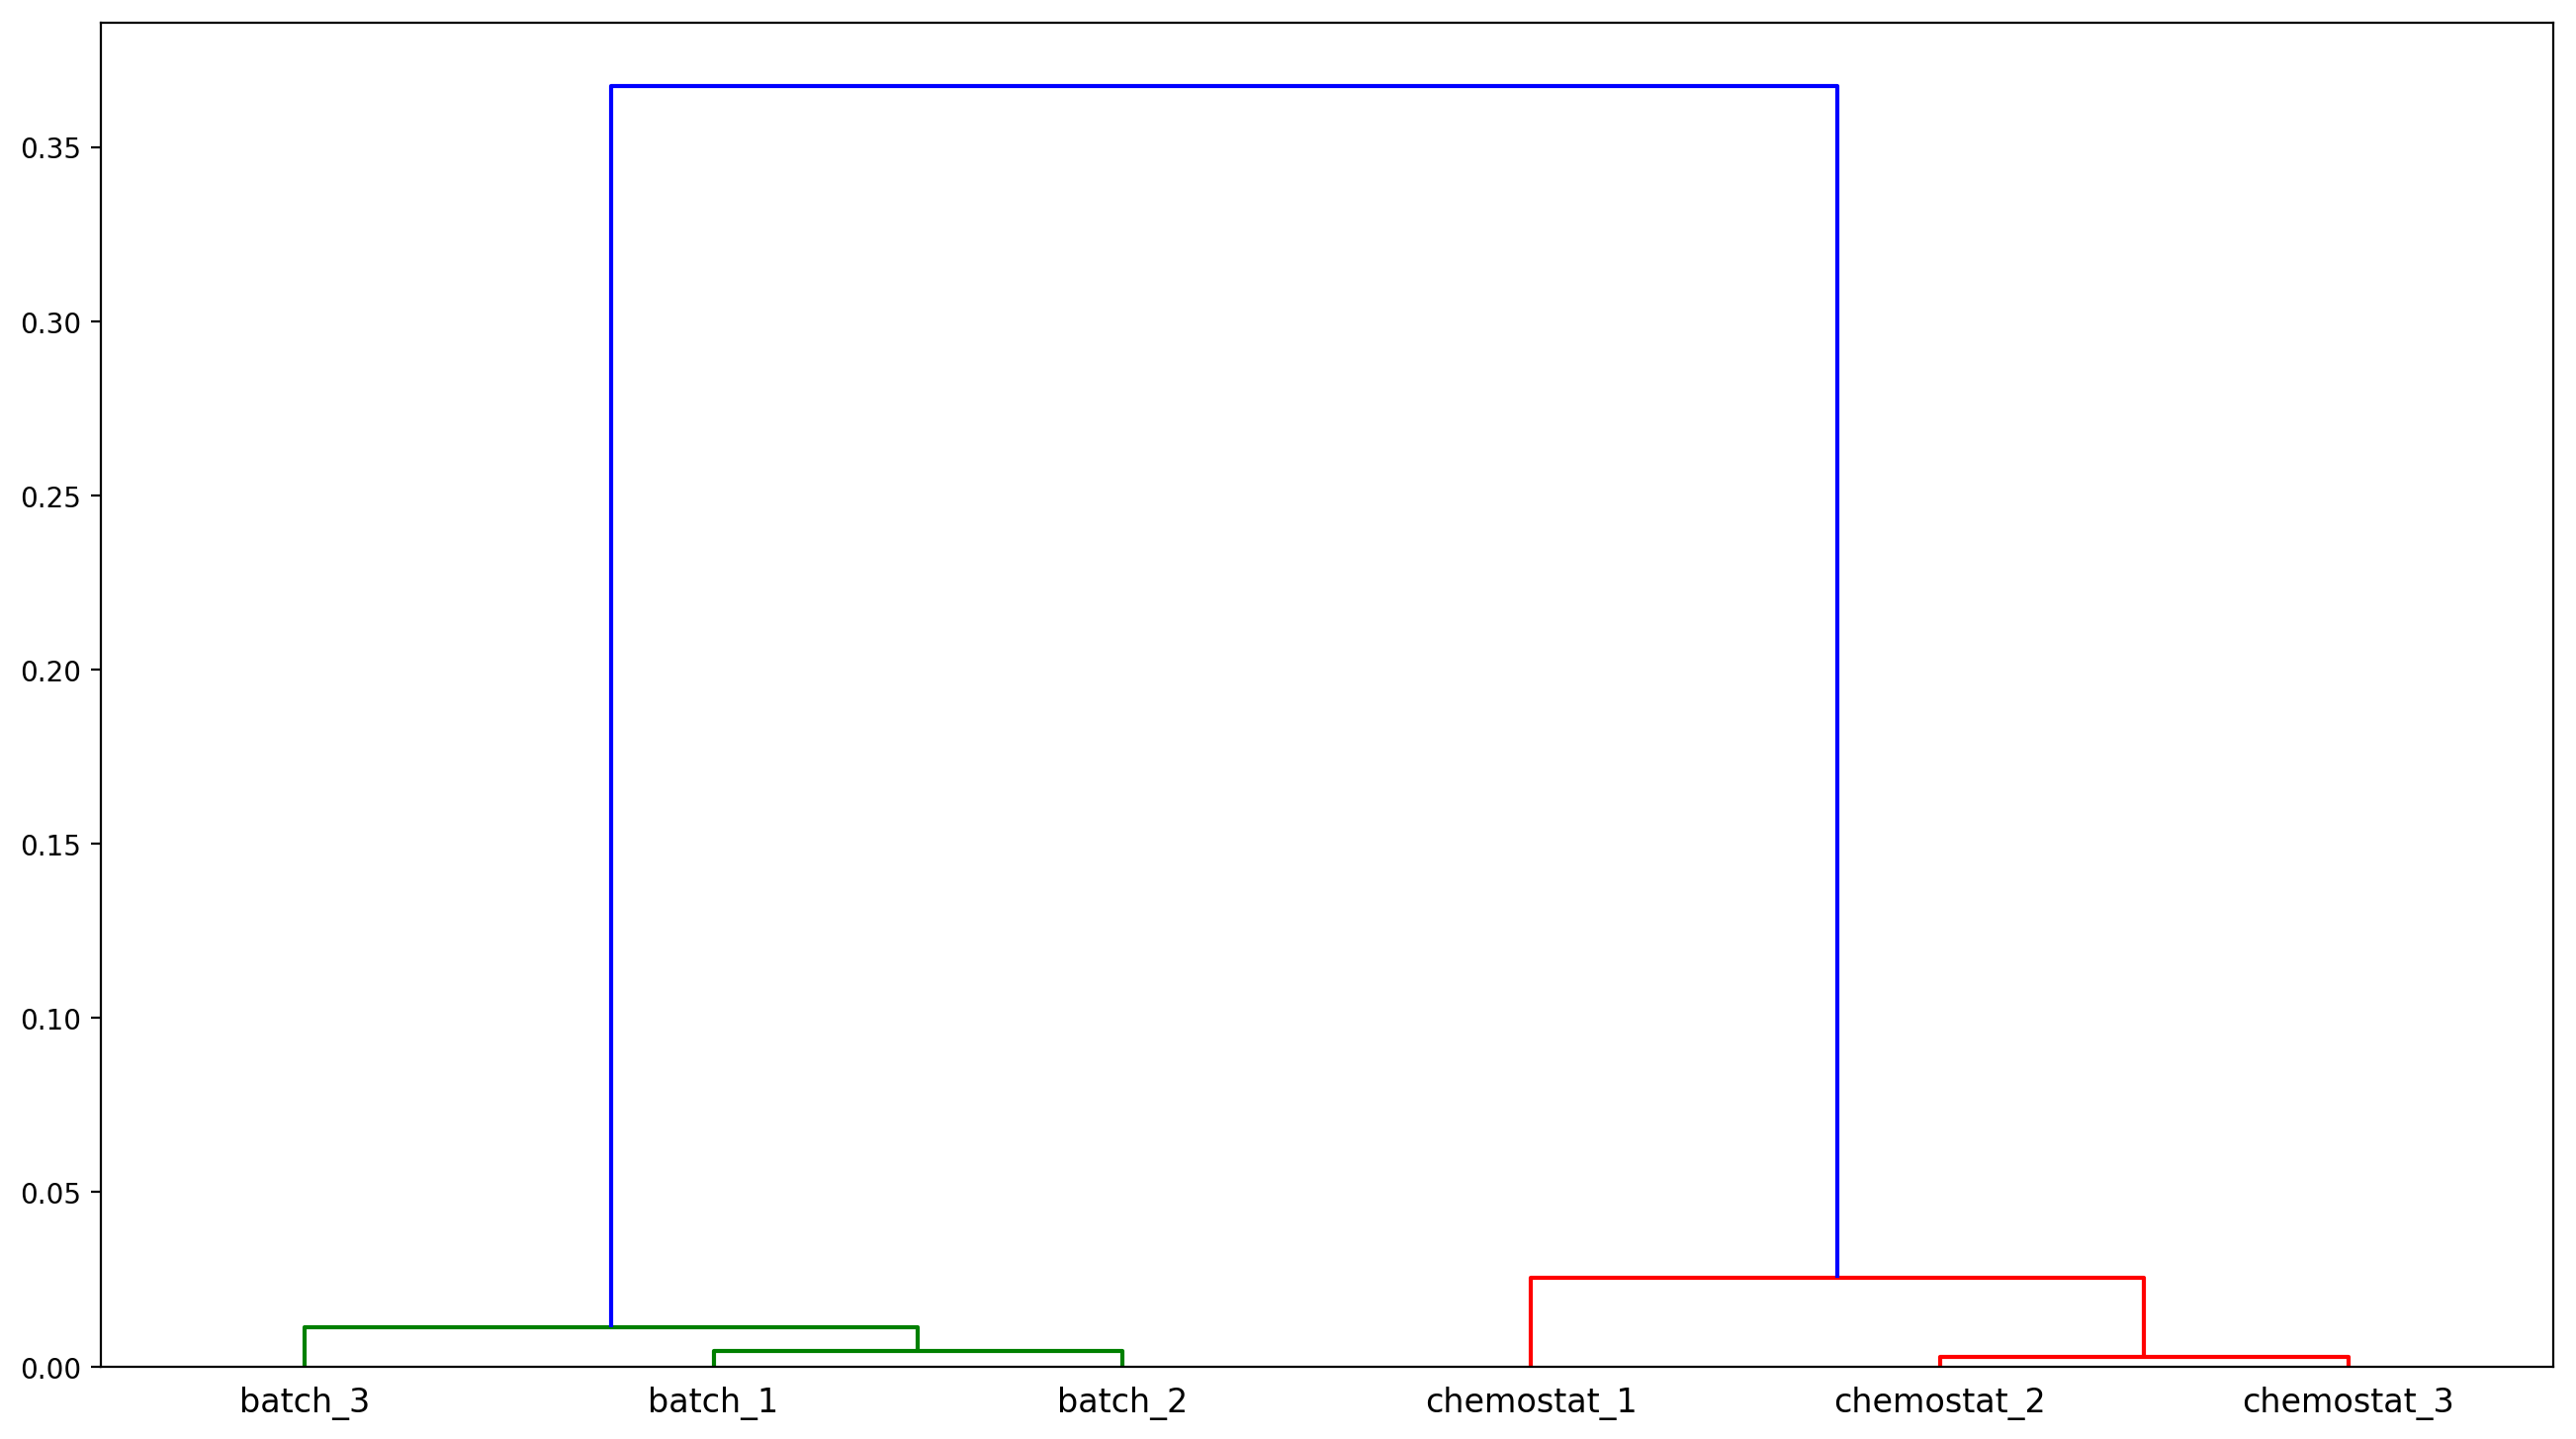

In [66]:
# 転置
fpkm_t = df_count_fpkm.T

# 平均とlog2foldの行を削除
fpkm_t = fpkm_t.drop(['batch', 'chemostat', 'log2fold'])

# クラスタリング
linkage_result = linkage(fpkm_t, method='average', metric='correlation')

# 結果の可視化
plt.figure(num=None, figsize=(16, 9), dpi=200, facecolor='w', edgecolor='k')
dendrogram(linkage_result,labels = list(fpkm_t.index) )
plt.show()